In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)

        self.current = df.iloc[x_size:, 7:8].values
        self.voltage = df.iloc[x_size:, 9:10].values

        self.y = df.iloc[x_size:, 13:14].values

        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src1 = np.zeros([enc_seq_len, num_samples])
        src2 = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])


        self.current = self.current.squeeze()
        self.voltage = self.voltage.squeeze()
        self.y = self.y.squeeze()

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src1[:,i] = self.current[start_x:end_x]
            src2[:,i] = self.voltage[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            # trg1[:,i] = self.current[start_y:end_y]
            # trg2[:,i] = self.voltage[start_y:end_y]
            trg[:,i] = self.y[start_y:end_y]

        src1 = src1.reshape(src1.shape[0], src1.shape[1], 1).transpose((1,0,2))
        src2 = src2.reshape(src2.shape[0], src2.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        self.src1 = src1
        self.src2 = src2
        self.trg = trg


        self.len = len(src1)

    def __getitem__(self, i):
        return self.src1[i], self.src2[i], self.trg[i]
    
    def __len__(self):
        return self.len

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [4]:
train_dataset = StrideDataset("DST_80.csv", 1000, 2, 1919, stride=2)
dataset_d = CustomDataset("DST_80.csv", 1919)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=False)

In [5]:
print(train_dataset.src1.shape)
print(train_dataset.trg.shape)

(4819, 1000, 1)
(4819, 2, 1)


In [6]:
print(dataset_d.y.shape)
print(dataset_d.y.shape)

(10639, 1)
(10639, 1)


In [7]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear((d_model), (d_model)//2),
            nn.ReLU(),
            nn.Linear((d_model)//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw*2, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    # def forward(self, src, srcmask):
    #     src = self.encoder(src)
    #     src = self.pos_encoder(src)
    #     output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
    #     output = self.linear(output)[:,:,0]
    #     output = self.linear2(output)
    #     return output

    def forward(self, src1, src2, srcmask):
        src1 = self.encoder(src1)
        src1 = self.pos_encoder(src1)

        src2 = self.encoder(src2)
        src2 = self.pos_encoder(src2)

        output_1 = self.transformer_encoder(src1.transpose(0,1), srcmask).transpose(0,1)
        output_2 = self.transformer_encoder(src2.transpose(0,1), srcmask).transpose(0,1)

        output = torch.cat([output_1, output_2], dim=1)
        

        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output
        




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [8]:
lr = 0.001
model = TFModel(1000, 2, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
epoch = 3
model.train()
progress = tqdm(range(epoch))


for i in progress:
    batchloss = 0.0
    for (src1, src2, trg) in train_dataloader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(src1.shape[1]).to(device)
        result = model(src1.float().to(device), src2.float().to(device), src_mask)
        loss = criterion(result, trg[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))



    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
        
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 53.321796: 100%|██████████| 3/3 [05:28<00:00, 109.62s/it] 


In [10]:
eval_dataset = StrideDataset("DST_80.csv", 1000, 2, 1919, stride=2)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False, drop_last=False)

In [11]:
model.eval()

predictions = np.array([])

with torch.no_grad():
    for (src1, src2, outputs) in eval_dataloader:
        src_mask = model.generate_square_subsequent_mask(src1.shape[1]).to(device)
        #print(src1.shape)
        to_numpy = model(src1.float().to(device), src2.float().to(device), src_mask).detach().cpu().numpy()
            
        predictions = np.append(predictions, to_numpy)


print(predictions.shape)

(9638,)


(0.0, 100.0)

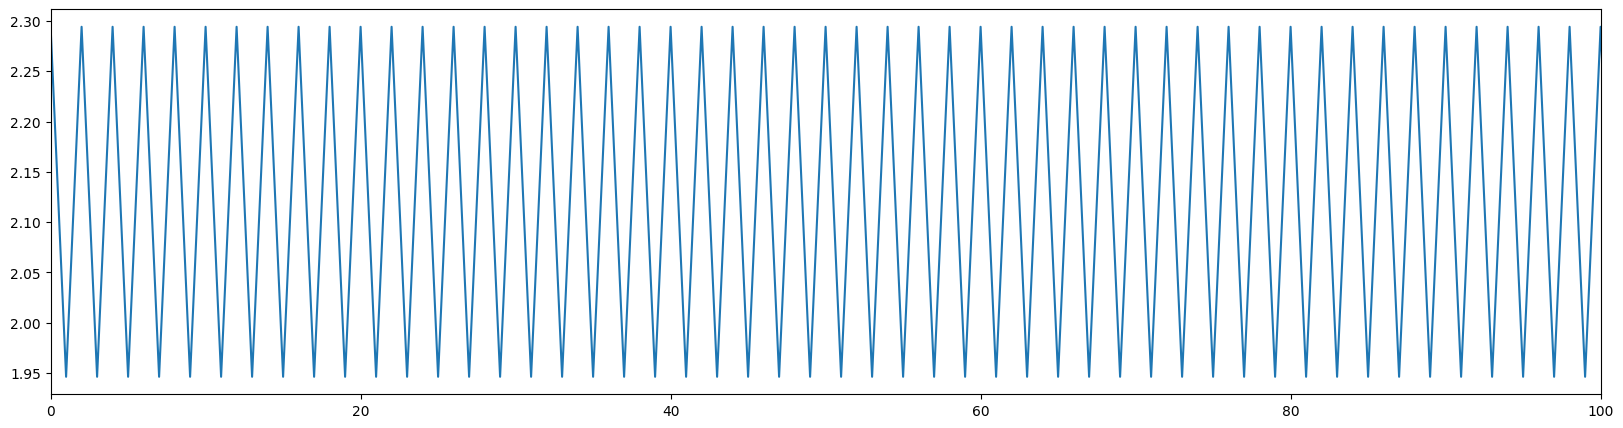

In [15]:
plt.figure(figsize=(20,5))
# plt.plot(range(20000-639,20000),dataset_d.y[20000-639:], label="real")
plt.plot(predictions, label="predict")
#plt.plot(dataset_d.y[500:], label="real")
plt.xlim([0, 100])

# plt.legend()
# plt.show()

In [13]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()